## Get Dataset

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# setup cell to make our lives easier 
import re
import numpy as np
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from utils import *
from customize_dataset import DexNetNPZDataset
from customize_dataset import DexNetNPZDatasetAll

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import GradScaler, autocast

tensor_dir = '../../dexnet_2.1/dexnet_2.1_eps_10/tensors/'  # replace with actual path
batch_size = 32
use_regression = False  # or True
pose_dims = [2]  


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# setup block. Run me!
print(torch.cuda.device_count())
print(torch.cuda.get_device_name())
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

1
NVIDIA GeForce RTX 3060 Laptop GPU


### Data Directory Analysis

In [9]:
# Get File Names and Categories and Data Amount
# File exploration

# Example usage:
analyze_directory("../../dexnet_2.1/dexnet_2.1_eps_10/tensors")

Category: camera_intrs_
  Number of files: 17
  Number range: 0 to 16
Category: camera_poses_
  Number of files: 17
  Number range: 0 to 16
Category: depth_ims_tf_table_
  Number of files: 17
  Number range: 0 to 16
Category: grasped_obj_keys_
  Number of files: 17
  Number range: 0 to 16
Category: grasp_collision_metrics_
  Number of files: 17
  Number range: 0 to 16
Category: grasp_metrics_
  Number of files: 17
  Number range: 0 to 16
Category: hand_poses_
  Number of files: 17
  Number range: 0 to 16
Category: labels_
  Number of files: 17
  Number range: 0 to 16
Category: pile_ids_
  Number of files: 17
  Number range: 0 to 16
Category: traj_ids_
  Number of files: 17
  Number range: 0 to 16

Inspecting one file per category:

Sample file for category 'camera_intrs_': camera_intrs_00000.npz
  Key: arr_0, Shape: (1000, 4)

Sample file for category 'camera_poses_': camera_poses_00000.npz
  Key: arr_0, Shape: (1000, 7)

Sample file for category 'depth_ims_tf_table_': depth_ims_tf_tab

Selected file number: 00012, sample index: 795

camera_poses_00012 -> Example[795]: [-0.07637229  0.96445644  0.25219193 -0.01975517  0.05543973 -0.09937388
  0.7144969 ]

hand_poses_00012 -> Example[795]: [3.7600000e+02 1.7800000e+02 7.3955172e-01 5.9245725e+00 1.0744258e-03
 3.5000000e+01]



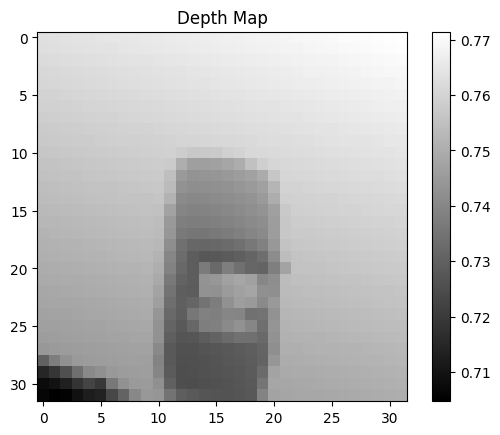

labels_00012 -> Example[795]: 1

traj_ids_00012 -> Example[795]: 7782



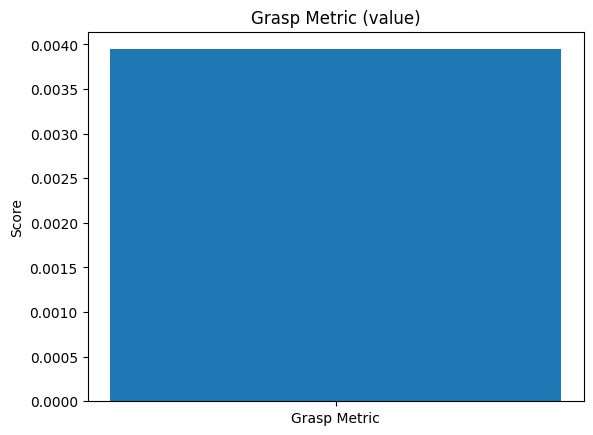

camera_intrs_00012 -> Example[795]: [521.08496 521.08496 299.      299.     ]

grasped_obj_keys_00012 -> Example[795]: b'c6709eb00a557c9785af3668c1cb30b'

grasp_collision_metrics_00012 -> Example[795]: 0.003945905715227127

pile_ids_00012 -> Example[795]: 6046



In [10]:
# Define all categories and their shape descriptions
categories = {
    'camera_poses_': (1000, 7),
    'hand_poses_': (1000, 6),
    'depth_ims_tf_table_': (466, 32, 32, 1),
    'labels_': (1000,),
    'traj_ids_': (1000,),
    'grasp_metrics_': (1000,),
    'camera_intrs_': (1000, 4),
    'grasped_obj_keys_': (1000,),
    'grasp_collision_metrics_': (1000,),
    'pile_ids_': (1000,)
}

def load_file(path, category, file_num):
    fname = f"{category}{file_num:05d}.npz"
    fpath = os.path.join(path, fname)
    return np.load(fpath)['arr_0']

# Example usage
# Replace this path with the actual path to your data folder
visualize_random_example("../../dexnet_2.1/dexnet_2.1_eps_10/tensors")


In [ ]:
# dataset['image']['depth_ims']     # Shape: (N, 32, 32)   — depth image
# dataset['pose']                   # Shape: (N, 4)        — grasp pose (x, y, z, angle)
# dataset['success']                # Shape: (N,)          — binary label: success/failure


In [ ]:
# Load dataset with regression labels and full 6D poses

dataset = DexNetNPZDatasetAll(tensor_dir='../../dexnet_2.1/dexnet_2.1_eps_10/tensors/', use_regression=True, pose_dims=[0, 1, 2, 3, 4, 5])
img, pose, label = dataset[0]
print(img.shape)    # torch.Size([3, 32, 32])
print(pose.shape)   # torch.Size([6])
print(label)        # A float (grasp quality)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)


torch.Size([1, 32, 32])
torch.Size([6])
tensor(0.0021)


In [ ]:
for i in dataloader:
    print(i[0].shape, i[1])
    break


In [ ]:
i[0].shape

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 1)  # Binary classification (grasp success)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (B, 16, 15, 15)
        x = self.pool(F.relu(self.conv2(x)))  # (B, 32, 6, 6)
        x = x.view(-1, 32 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class ResNetGraspNet(nn.Module):
    """
    A binary classification model for grasp success using ResNet-50 as a backbone.
    """
    def __init__(self, pretrained: bool = True, num_classes: int = 1, dropout_rate: float = 0.2):
        super(ResNetGraspNet, self).__init__()
        # Load ResNet-50 backbone with optional ImageNet pretrained weights
        weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.backbone = resnet50(weights=weights)
        # Retrieve number of input features to the classifier head
        in_features = self.backbone.fc.in_features
        # Replace the original classification head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through ResNet-50 and sigmoid head
        return self.backbone(x)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

class EfficientNetV2GraspNet(nn.Module):
    """
    A binary classification model for grasp success using EfficientNet-V2-S as a backbone.
    """
    def __init__(self, pretrained: bool = True, num_classes: int = 1, dropout_rate: float = 0.2):
        super(EfficientNetV2GraspNet, self).__init__()
        # Load EfficientNet-V2-S backbone with optional ImageNet pretrained weights
        weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = efficientnet_v2_s(weights=weights)
        # Retrieve number of input features to the classifier head
        in_features = self.backbone.classifier[1].in_features
        # Replace the classifier head for binary grasp success prediction
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate, inplace=True),
            nn.Linear(in_features, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through EfficientNet-V2 and sigmoid head
        return self.backbone(x)

### Forward Pass and Evaluation Measurements Define

In [ ]:
dataloader

### Model Training

In [ ]:
for i in model.parameters():
    print(i.shape)

In [ ]:
# model = SimpleCNN()
model = EfficientNetV2GraspNet()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from tqdm import tqdm
for epoch in range(3):
    for imgs, labels in tqdm(dataloader):
        outputs = model(imgs)
        loss = criterion(outputs.squeeze(), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        break


In [ ]:
import torch
from tqdm import tqdm

num_epochs = 3
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for imgs, labels in progress_bar:
        outputs = model(imgs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        running_loss += loss.item() * imgs.size(0)

        # Optional: compute accuracy
        predicted = (outputs >= 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        break

    epoch_loss = running_loss / total
    accuracy = correct / total

    loss_history.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] — Loss: {epoch_loss:.4f} — Accuracy: {accuracy:.4f}")


In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()


## Image + Poses Model

In [24]:
class SimpleGQCNN(nn.Module):
    def __init__(self, pose_dim=4, output_type='binary', merge_methods="element_dot"):
        """
        pose_dim: number of dimensions in the pose vector (e.g., x, y, z, theta)
        output_type: 'binary' or 'regression'
        """
        super(SimpleGQCNN, self).__init__()
        self.output_type = output_type

        # Image stream
        self.conv1 = nn.Conv2d(1, 16, 3)           # → (B, 16, 30, 30)
        self.pool = nn.MaxPool2d(2, 2)             # → (B, 16, 15, 15)
        self.conv2 = nn.Conv2d(16, 32, 3)          # → (B, 32, 13, 13) → pool → (B, 32, 6, 6)
        self.im_fc = nn.Linear(32 * 6 * 6, 64)     # → (B, 64)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.im_fc_bn = nn.BatchNorm1d(64)

        # Pose stream
        self.pose_fc1 = nn.Linear(pose_dim, 64)
        self.pose_fc2 = nn.Linear(64, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.merge_methods = merge_methods
        if self.merge_methods == "element_dot":
            # Merge stream after elementwise multiplication
            self.merge_fc1 = nn.Linear(64, 32)
            self.merge_fc2 = nn.Linear(32, 1)
        else:
            # Merge stream by concatanation
            self.merge_fc1 = nn.Linear(64 + 64, 64)
            self.merge_fc2 = nn.Linear(64, 1)  # Single output for binary or regression

    def forward(self, image, pose):
        
        # Image stream
        x = self.pool(F.relu(self.bn1(self.conv1(image))))   # (B, 16, 15, 15)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       # (B, 32, 6, 6)
        # x = x.view(x.size(0), -1)                  # Flatten
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.im_fc(x))                  # (B, 64)

        # Pose stream
        p = self.dropout(F.relu(self.pose_fc1(pose)))            # (B, 64)
        p = self.dropout(F.relu(self.pose_fc2(p)))               # (B, 64)

        if self.merge_methods == "element_dot":
            # Element-wise multiplication
            combined = x * p                           # (B, 64)
        else:
            # Merge
            combined = torch.cat((x, p), dim=1)       # -> (B, 96)

        # Final layers
        out = F.relu(self.merge_fc1(combined))     # (B, 32)
        out = self.merge_fc2(out)                  # (B, 1)

        # if self.output_type == 'binary':
        #     out = torch.sigmoid(out)               # Binary prediction
        return out 


In [12]:
model = SimpleGQCNN(pose_dim=4, output_type='regression')  # or 'binary'

image = torch.randn(8, 1, 32, 32)  # Batch of 8 grayscale images
pose = torch.randn(8, 4)          # Corresponding batch of 4D poses

output = model(image, pose)
# print(output.shape)  # torch.Size([8, 1])


In [13]:
# Set config
tensor_dir = '../../dexnet_2.1/dexnet_2.1_eps_10/tensors/'  # replace with actual path
batch_size = 32
use_regression = False  # or True
pose_dims = [2]          # or full [0, 1, 2, 3, 4, 5]
# torch.backends.cudnn.benchmark = True

# Create dataset and dataloader
train_loader, val_loader = DexNetDataloader(tensor_dir=tensor_dir, use_regression=use_regression)

model = SimpleGQCNN(pose_dim=len(pose_dims), output_type='regression' if use_regression else 'binary')

model = model.to(device, memory_format=torch.channels_last)

if use_regression:
    criterion = nn.MSELoss()
else:
    criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)


In [30]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device,
          threshold=0.5, num_epochs=10, save_dir="/eps_10/"):

    model = model.to(device, memory_format=torch.channels_last)
    scaler = GradScaler()

    train_losses = []
    val_losses = []
    accuracy_scores = []
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training Loop
        for images, poses, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}] Training"):
            images = images.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            poses = poses.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(1)

            optimizer.zero_grad()
            with autocast("cuda"):
                outputs = model(images, poses)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 🔍 Evaluation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, poses, labels in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation"):
                images = images.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
                poses = poses.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True).unsqueeze(1)

                with autocast("cuda"):
                    outputs = model(images, poses)
                    loss = criterion(outputs, labels)
                    outputs = torch.sigmoid(outputs)
                    predictions = (outputs >= threshold).float()  # binary threshold
                    correct += (predictions == labels).sum().item()
                    total += labels.size(0)

                val_loss += loss.item()
        
        accuracy = correct / total
        accuracy_scores.append(accuracy)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, LR = {current_lr:.2e}")
        print(f"✅ Accuracy: {accuracy * 100:.2f}%")
        # ✅ Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), save_dir+rf"model.pth")
            print(f"✔️ Saved best model to '{save_dir+r"model.pth"}'")

    # 📊 Plot training & validation loss
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_dir+"loss_curve.png")
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(accuracy_scores, label='Accuracy Scores')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy on Validation Dataset")
    plt.tight_layout()
    plt.savefig(save_dir+"accuracy_scores.png")
    plt.show()

    return train_losses, val_losses


[Epoch 1] Validation: 100%|██████████| 103/103 [00:37<00:00,  2.78it/s]


Epoch 1: Train Loss = 0.5372, Val Loss = 0.3925, LR = 1.00e-04
✅ Accuracy: 85.24%
✔️ Saved best model to 'eps_10/model.pth'


[Epoch 2] Validation: 100%|██████████| 103/103 [00:36<00:00,  2.79it/s]


Epoch 2: Train Loss = 0.3747, Val Loss = 0.3362, LR = 1.00e-04
✅ Accuracy: 85.58%
✔️ Saved best model to 'eps_10/model.pth'


[Epoch 3] Validation: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


Epoch 3: Train Loss = 0.3455, Val Loss = 0.3339, LR = 1.00e-04
✅ Accuracy: 88.49%
✔️ Saved best model to 'eps_10/model.pth'


[Epoch 4] Validation: 100%|██████████| 103/103 [00:36<00:00,  2.83it/s]


Epoch 4: Train Loss = 0.3137, Val Loss = 0.3457, LR = 1.00e-04
✅ Accuracy: 88.70%


[Epoch 5] Validation: 100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


Epoch 5: Train Loss = 0.2986, Val Loss = 0.2737, LR = 1.00e-04
✅ Accuracy: 90.92%
✔️ Saved best model to 'eps_10/model.pth'


[Epoch 6] Validation: 100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


Epoch 6: Train Loss = 0.2825, Val Loss = 0.2698, LR = 1.00e-04
✅ Accuracy: 90.80%
✔️ Saved best model to 'eps_10/model.pth'


[Epoch 7] Validation: 100%|██████████| 103/103 [00:35<00:00,  2.93it/s]


Epoch 7: Train Loss = 0.2680, Val Loss = 0.2777, LR = 1.00e-04
✅ Accuracy: 91.38%


[Epoch 8] Validation: 100%|██████████| 103/103 [00:35<00:00,  2.91it/s]


Epoch 8: Train Loss = 0.2598, Val Loss = 0.2612, LR = 1.00e-04
✅ Accuracy: 91.86%
✔️ Saved best model to 'eps_10/model.pth'


[Epoch 9] Validation: 100%|██████████| 103/103 [00:34<00:00,  2.95it/s]


Epoch 9: Train Loss = 0.2464, Val Loss = 0.2775, LR = 1.00e-04
✅ Accuracy: 90.68%


[Epoch 10] Validation: 100%|██████████| 103/103 [00:35<00:00,  2.94it/s]


Epoch 10: Train Loss = 0.2434, Val Loss = 0.2832, LR = 1.00e-04
✅ Accuracy: 92.17%


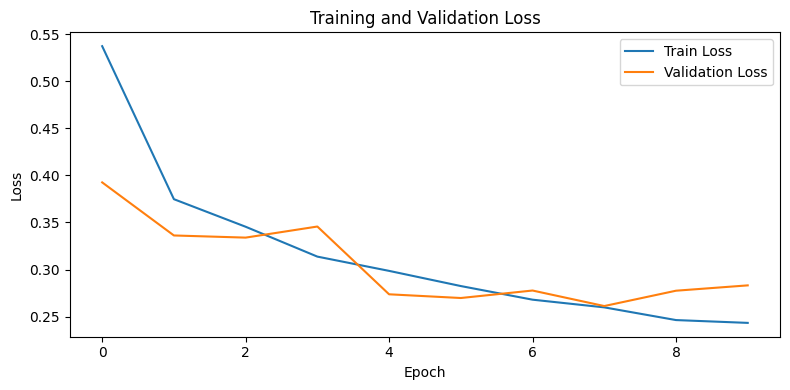

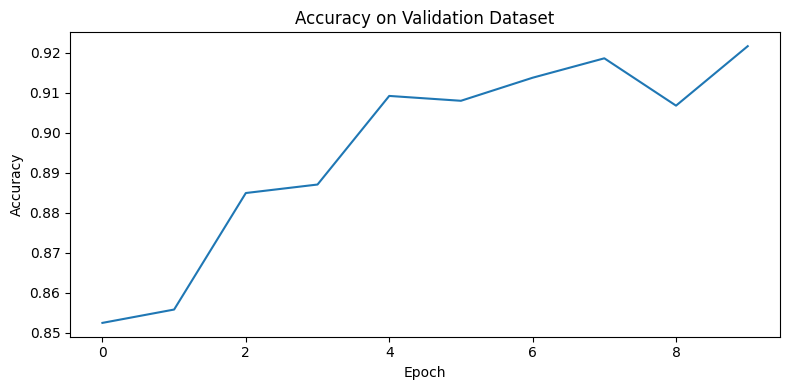

[Epoch 1] Validation: 100%|██████████| 218/218 [00:56<00:00,  3.84it/s]


Epoch 1: Train Loss = 0.5608, Val Loss = 0.4313, LR = 1.00e-04
✅ Accuracy: 81.12%
✔️ Saved best model to 'eps_50/model.pth'


[Epoch 2] Validation: 100%|██████████| 218/218 [00:46<00:00,  4.66it/s]


Epoch 2: Train Loss = 0.4488, Val Loss = 0.4543, LR = 1.00e-04
✅ Accuracy: 81.84%


[Epoch 3] Validation: 100%|██████████| 218/218 [00:56<00:00,  3.84it/s]


Epoch 3: Train Loss = 0.4238, Val Loss = 0.4350, LR = 1.00e-04
✅ Accuracy: 82.07%


[Epoch 4] Validation: 100%|██████████| 218/218 [00:58<00:00,  3.74it/s]


Epoch 4: Train Loss = 0.4032, Val Loss = 0.4151, LR = 1.00e-04
✅ Accuracy: 82.18%
✔️ Saved best model to 'eps_50/model.pth'


[Epoch 5] Validation: 100%|██████████| 218/218 [00:46<00:00,  4.66it/s]


Epoch 5: Train Loss = 0.3927, Val Loss = 0.3776, LR = 1.00e-04
✅ Accuracy: 84.04%
✔️ Saved best model to 'eps_50/model.pth'


[Epoch 6] Validation: 100%|██████████| 218/218 [00:44<00:00,  4.88it/s]


Epoch 6: Train Loss = 0.3788, Val Loss = 0.3814, LR = 1.00e-04
✅ Accuracy: 83.94%


[Epoch 7] Validation: 100%|██████████| 218/218 [00:43<00:00,  4.96it/s]


Epoch 7: Train Loss = 0.3747, Val Loss = 0.3940, LR = 1.00e-04
✅ Accuracy: 83.72%


[Epoch 8] Validation: 100%|██████████| 218/218 [00:44<00:00,  4.86it/s]


Epoch 8: Train Loss = 0.3686, Val Loss = 0.3567, LR = 1.00e-04
✅ Accuracy: 84.86%
✔️ Saved best model to 'eps_50/model.pth'


[Epoch 9] Validation: 100%|██████████| 218/218 [01:00<00:00,  3.60it/s]


Epoch 9: Train Loss = 0.3604, Val Loss = 0.4060, LR = 1.00e-04
✅ Accuracy: 83.12%


[Epoch 10] Validation: 100%|██████████| 218/218 [01:00<00:00,  3.59it/s]


Epoch 10: Train Loss = 0.3581, Val Loss = 0.4409, LR = 1.00e-04
✅ Accuracy: 82.01%


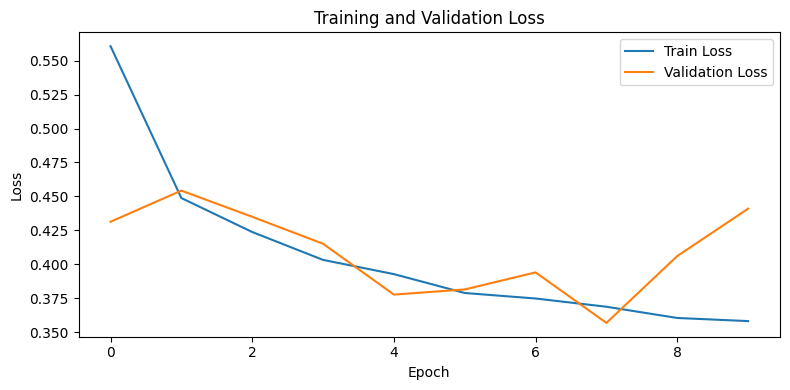

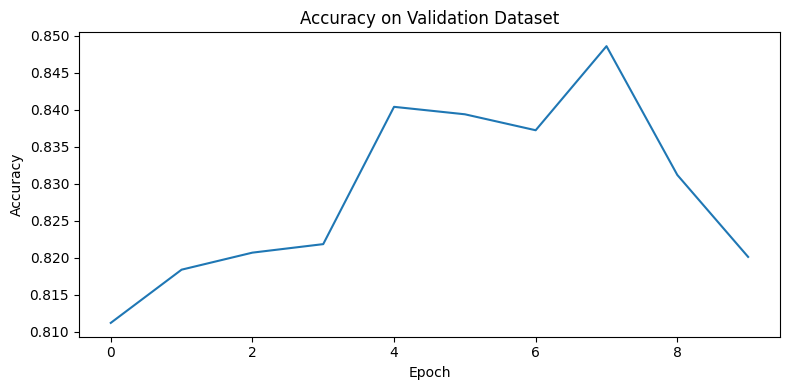

[Epoch 1] Validation: 100%|██████████| 642/642 [02:17<00:00,  4.67it/s]


Epoch 1: Train Loss = 0.2697, Val Loss = 0.2212, LR = 1.00e-04
✅ Accuracy: 90.17%
✔️ Saved best model to 'eps_90/model.pth'


[Epoch 2] Validation: 100%|██████████| 642/642 [02:03<00:00,  5.21it/s]


Epoch 2: Train Loss = 0.2248, Val Loss = 0.2075, LR = 1.00e-04
✅ Accuracy: 90.17%
✔️ Saved best model to 'eps_90/model.pth'


[Epoch 3] Validation: 100%|██████████| 642/642 [01:34<00:00,  6.81it/s]


Epoch 3: Train Loss = 0.2151, Val Loss = 0.2089, LR = 1.00e-04
✅ Accuracy: 90.17%


[Epoch 4] Validation: 100%|██████████| 642/642 [01:32<00:00,  6.97it/s]


Epoch 4: Train Loss = 0.2107, Val Loss = 0.2080, LR = 1.00e-04
✅ Accuracy: 90.17%


[Epoch 5] Validation: 100%|██████████| 642/642 [01:30<00:00,  7.07it/s]


Epoch 5: Train Loss = 0.2065, Val Loss = 0.2072, LR = 1.00e-04
✅ Accuracy: 90.17%
✔️ Saved best model to 'eps_90/model.pth'


[Epoch 6] Validation: 100%|██████████| 642/642 [01:29<00:00,  7.15it/s]


Epoch 6: Train Loss = 0.2022, Val Loss = 0.2051, LR = 1.00e-04
✅ Accuracy: 90.17%
✔️ Saved best model to 'eps_90/model.pth'


[Epoch 7] Validation: 100%|██████████| 642/642 [36:35<00:00,  3.42s/it]    


Epoch 7: Train Loss = 0.1982, Val Loss = 0.2087, LR = 1.00e-04
✅ Accuracy: 90.17%


[Epoch 8] Validation: 100%|██████████| 642/642 [02:12<00:00,  4.84it/s]


Epoch 8: Train Loss = 0.1986, Val Loss = 0.2182, LR = 1.00e-04
✅ Accuracy: 90.17%


[Epoch 9] Validation: 100%|██████████| 642/642 [02:10<00:00,  4.94it/s]


Epoch 9: Train Loss = 0.1948, Val Loss = 0.1991, LR = 1.00e-04
✅ Accuracy: 90.17%
✔️ Saved best model to 'eps_90/model.pth'


[Epoch 10] Validation: 100%|██████████| 642/642 [02:01<00:00,  5.28it/s]


Epoch 10: Train Loss = 0.1929, Val Loss = 0.2112, LR = 1.00e-04
✅ Accuracy: 90.17%


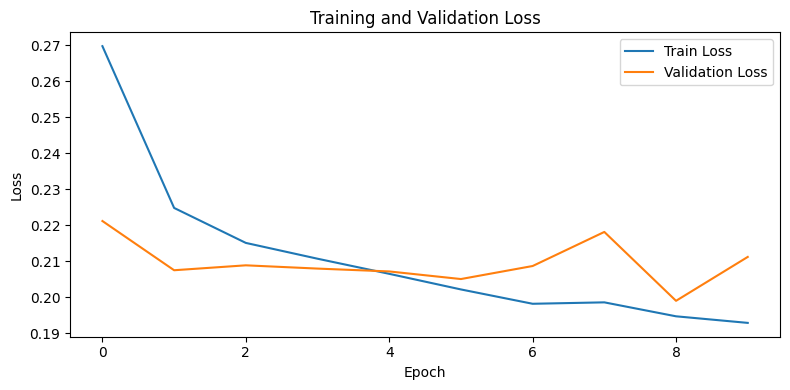

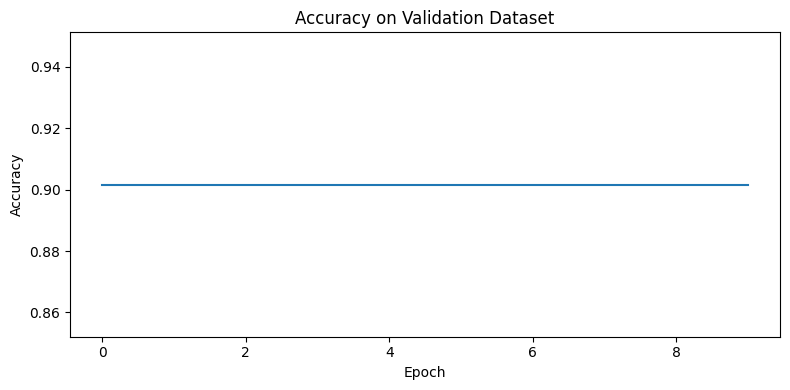

In [31]:
eps = [10, 50, 90]
pose_dims = [0, 1, 2, 3, 4, 5]
# torch.backends.cudnn.benchmark = True
for ep in eps:
    tensor_dir = rf"../../dexnet_2.1/dexnet_2.1_eps_{ep}/tensors/"
    # Create dataset and dataloader
    train_loader, val_loader = DexNetDataloader(tensor_dir=tensor_dir, use_regression=use_regression, pose_dims=pose_dims)
    # Train run
    model = SimpleGQCNN(pose_dim=len(pose_dims), output_type='regression' if use_regression else 'binary')

    model = model.to(device, memory_format=torch.channels_last)

    if use_regression:
        criterion = nn.MSELoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, save_dir=rf"eps_{ep}/")

In [29]:
# load SimpleGQCNN
model = SimpleGQCNN(pose_dim=len(pose_dims), output_type='regression' if use_regression else 'binary')
model.load_state_dict(torch.load("model.pth", weights_only=True))
model = model.to(device, memory_format=torch.channels_last)

In [ ]:
accuracy = evaluate_accuracy(model, val_loader, device)

✅ Accuracy: 93.87%
